In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
import numpy as np
import pandas as pd
import collections

In [2]:
x_name = os.path.join(os.getcwd(), '데이터SET', f"{'[Track1_데이터3] samp_cst_feat'}.csv")
df_x = pd.read_csv(x_name, index_col=0)

y_name = os.path.join(os.getcwd(), '데이터SET', f"{'[Track1_데이터2] samp_train'}.csv")
df_y = pd.read_csv(y_name, index_col=0)

df = pd.merge(df_x, df_y, on='cst_id_di')

In [3]:
df.MRC_ID_DI[df.MRC_ID_DI > 0 ] = 1

C:\Users\jym97\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [4]:
nc_name = os.path.join(os.getcwd(), '데이터SET', f"{'[Track1_데이터4] variable_dtype'}.xlsx")
nc = pd.read_excel(nc_name, index_col=0)

In [5]:
X = df.drop(columns = ['MRC_ID_DI'], axis=1)
y = df['MRC_ID_DI']

In [6]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random

#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [7]:
import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                      exception_only=False, running_compiled_code=False):
       etype, value, tb = sys.exc_info()
       return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

In [8]:
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures

def add_interactions(df):
    combos = list(combinations(list(df.columns), 2))
    colnames = list(df.columns) + ['_'.join(x) for x in combos]
    
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames
    
    noint_indicies = [i for i, x in enumerate(list((df == 0).all())) if x]
    df = df.drop(df.columns[noint_indicies], axis = 1)
    
    return df

X = add_interactions(X)


import sklearn.feature_selection

select = sklearn.feature_selection.SelectKBest(k=331)
selected_features = select.fit(X, y)
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [X.columns[i] for i in indices_selected]

X = X[colnames_selected]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify = y)

In [10]:
train = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
train_0 = train[train['MRC_ID_DI'] == 0].sample(frac=1)
train_1 = train[train['MRC_ID_DI'] == 1].sample(frac=1)

sample_size = len(train_0) if len(train_0) < len(train_1) else len(train_1)

train_f = pd.concat([train_0.head(sample_size), train_1.head(sample_size)]).sample(frac=1)

X_train = train_f.drop(columns = ['MRC_ID_DI'], axis=1)
y_train = train_f['MRC_ID_DI']

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [11]:
input_ = tf.keras.Input(dtype = tf.float32, shape = (len(X.columns),))

dense_layer_1_1 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(input_)
dense_layer_1_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_1)
dense_layer_1_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_2)
dense_layer_1_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_3)

dropout_1_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_1_1)

output = tf.keras.layers.Dense(units = 2, activation = tf.nn.softmax)(dropout_1_5)

In [12]:
model = tf.keras.Model(inputs=input_, outputs=output)

In [13]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
              optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=0.00005), 
              metrics=['accuracy'])
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 331)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                10624     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 66        
Total params: 10,690
Trainable params: 10,690
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
#history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=400, verbose=1, validation_split=0.1)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40)
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=10000, verbose=1, validation_split=0.1, callbacks=[callback])

Epoch 1/10000
98/98 [==============================] - 0s 4ms/step - loss: 0.7306 - accuracy: 0.4787 - val_loss: 0.6414 - val_accuracy: 0.7032
Epoch 2/10000
98/98 [==============================] - 0s 2ms/step - loss: 0.5836 - accuracy: 0.7358 - val_loss: 0.5744 - val_accuracy: 0.7147
Epoch 3/10000
98/98 [==============================] - 0s 2ms/step - loss: 0.5365 - accuracy: 0.7429 - val_loss: 0.5589 - val_accuracy: 0.7147
Epoch 4/10000
98/98 [==============================] - 0s 2ms/step - loss: 0.5216 - accuracy: 0.7406 - val_loss: 0.5541 - val_accuracy: 0.7118
Epoch 5/10000
98/98 [==============================] - 0s 2ms/step - loss: 0.5179 - accuracy: 0.7445 - val_loss: 0.5503 - val_accuracy: 0.7147
Epoch 6/10000
98/98 [==============================] - 0s 2ms/step - loss: 0.5125 - accuracy: 0.7467 - val_loss: 0.5479 - val_accuracy: 0.7176
Epoch 7/10000
98/98 [==============================] - 0s 2ms/step - loss: 0.5079 - accuracy: 0.7432 - val_loss: 0.5451 - val_accuracy: 0.7176

98/98 [==============================] - 0s 2ms/step - loss: 0.4657 - accuracy: 0.7750 - val_loss: 0.5163 - val_accuracy: 0.7579
Epoch 58/10000
98/98 [==============================] - 0s 2ms/step - loss: 0.4611 - accuracy: 0.7717 - val_loss: 0.5165 - val_accuracy: 0.7579
Epoch 59/10000
98/98 [==============================] - 0s 2ms/step - loss: 0.4628 - accuracy: 0.7750 - val_loss: 0.5161 - val_accuracy: 0.7550
Epoch 60/10000
98/98 [==============================] - 0s 2ms/step - loss: 0.4642 - accuracy: 0.7746 - val_loss: 0.5151 - val_accuracy: 0.7550
Epoch 61/10000
98/98 [==============================] - 0s 2ms/step - loss: 0.4607 - accuracy: 0.7775 - val_loss: 0.5174 - val_accuracy: 0.7550
Epoch 62/10000
98/98 [==============================] - 0s 2ms/step - loss: 0.4612 - accuracy: 0.7814 - val_loss: 0.5151 - val_accuracy: 0.7550
Epoch 63/10000
98/98 [==============================] - 0s 2ms/step - loss: 0.4599 - accuracy: 0.7730 - val_loss: 0.5157 - val_accuracy: 0.7522
Epoch 6

Epoch 114/10000
98/98 [==============================] - 0s 2ms/step - loss: 0.4399 - accuracy: 0.7971 - val_loss: 0.5105 - val_accuracy: 0.7406
Epoch 115/10000
98/98 [==============================] - 0s 2ms/step - loss: 0.4401 - accuracy: 0.7875 - val_loss: 0.5107 - val_accuracy: 0.7406
Epoch 116/10000
98/98 [==============================] - ETA: 0s - loss: 0.4417 - accuracy: 0.79 - 0s 2ms/step - loss: 0.4403 - accuracy: 0.7949 - val_loss: 0.5100 - val_accuracy: 0.7406
Epoch 117/10000
98/98 [==============================] - 0s 2ms/step - loss: 0.4386 - accuracy: 0.7942 - val_loss: 0.5130 - val_accuracy: 0.7406
Epoch 118/10000
98/98 [==============================] - 0s 2ms/step - loss: 0.4386 - accuracy: 0.7939 - val_loss: 0.5141 - val_accuracy: 0.7378
Epoch 119/10000
98/98 [==============================] - 0s 2ms/step - loss: 0.4375 - accuracy: 0.7939 - val_loss: 0.5133 - val_accuracy: 0.7378
Epoch 120/10000
98/98 [==============================] - 0s 2ms/step - loss: 0.4384 - ac

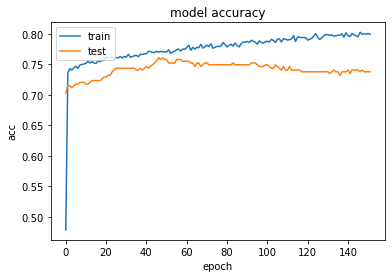

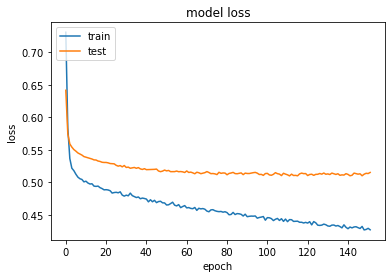

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [16]:
score = model.evaluate(x=X_test, y=y_test, verbose=1)

print("Test Score:", score[0])
print("Test ACC:", score[1])

32/32 [==============================] - 0s 982us/step - loss: 0.4867 - accuracy: 0.7453
Test Score: 0.4866892993450165
Test ACC: 0.7453109622001648


In [17]:
preds = model.predict(X_test, verbose=1)

32/32 [==============================] - 0s 873us/step


In [18]:
def LIFT(preds, y_test): # >=2.5
    condition = y_test.astype(bool) #preds에 정답인 예측 score만 남긴다.
    c = np.extract(condition, preds)
    b = np.argsort(-c)[:len(c)//5] #예측 score 상위 20%
    
    lift_20 = preds[b] 
    
    lift_20_flat = np.argmax(lift_20, axis=1) #값을 확률에서 0, 1값으로 바꾼다. 
    y_test_flat = np.argmax(y_test, axis=1)
    lift_20_1 = lift_20_flat[lift_20_flat == 1] #1인 경우만 남긴다. 
    y_1 = y_test_flat[y_test_flat == 1]
    
    lift_score = (len(lift_20_1)/len(lift_20_flat))/(len(y_1)/len(y_test_flat))
    print('LIFT Accuracy: ',  lift_score)
    return lift_score

In [19]:
lift_value = LIFT(preds, y_test)

LIFT Accuracy:  0.025983686451546712


In [20]:
m = tf.keras.metrics.AUC()
m.update_state(y_test, preds)
auroc_value = m.result().numpy()
print('AUROC: ', auroc_value)

AUROC:  0.84153634


In [21]:
final_score = (lift_value/5)*0.7 + (auroc_value)*0.3

    
print('fianle score: ', final_score)

fianle score:  0.25609861903252257


<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

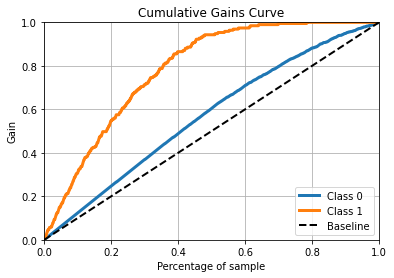

In [22]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(np.argmax(y_test, axis=1), preds)